# Segmentez les clients d'un site e-commerce - Part 3 : Maintenance

This notebook is the third in a series of 3. The first two respectively deal with an EDA and a Clustering. This third one aims at estimating a maintenance schedule of the clustering, i.e. providing the client with an "updates calendar" to follow.
We use Olist database available freely on Kaggle at this link: https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce

## Work preparation

In [1]:
# Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
import warnings
import functions

from sklearn.metrics import homogeneity_score, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.cluster import KMeans

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder

## Database slicing

Our goal is to estimate a maintenance contract schedule. We need to tell Olist when they'll most likely have to rerun a clustering analysis for the insights to be accurate at any given date.
First thing is to slice the dateset in several parts, each part representing a different timespan, and then determine the average timespan where the customers are most-likely to switch from a cluster to another one.

For this to bring interesting results, we need to have a first period of time where a sufficient number of clients is included. Indeed, if we take a 3-month period of time as starting timespan, we'll only have unique customers for those 3 months, and if they did not order much during the remaining of the full time period at study, we won't be able to detect changes in the clusters, simply because we do not observe those customers enough. 

The solution is therefore to have a quite important timespan as a starting point (for exampe, half of the total timespan we are covering, i.e. 1 year), and then see whether the clustering changes much over varying periods of time (2 months, 3 months, 4 months etc...)

The main difficulty that we encounter is that we have to compute all features for each slice of time. We make use of a function to do so.

In [2]:
# Initial period of 12 months
data_base = functions.split_dataset(dpath="./Data/", nb_months = 0)

mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
Feature engineering time to run: 10.27s


Now that we have the dataset for the baseline period, let's perform a quick research of parameters to find the optimal K on this specific time span.

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('kelbowvisualizer',
                 KElbowVisualizer(ax=<AxesSubplot:>, estimator=KMeans(),
                                  k=(2, 9)))])

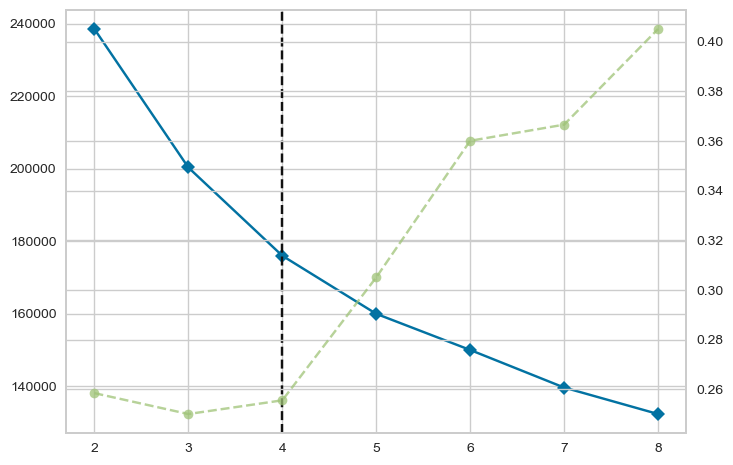

In [3]:
# Kmeans on initial period
# Clustering the baseline data

warnings.filterwarnings('ignore')

from yellowbrick.cluster import KElbowVisualizer
visualizer = KElbowVisualizer(KMeans(), k=(2,9))
kmeans_base = make_pipeline(RobustScaler(), visualizer)
kmeans_base.fit(data_base)

We find exactly the same number of clusters than with the full dataset: 4.

In [4]:
# Launching the KMeans with the optimal K = 4 for base period
optimal_K = visualizer.elbow_value_

kmeans_base.named_steps['kelbowvisualizer'].show()

kmeans_init = Pipeline([("preprocessor", RobustScaler()),
                        ("kmeans", KMeans(optimal_K))])
kmeans_init.fit(data_base)
init_labels = kmeans_init.named_steps['kmeans'].labels_

Penultimate step, we now launch the clustering for all periods of time. We decided to go for an increment of 2 month at each period, which corresponds to having 7 splits: 12 months for the baseline already computed, then 14 months, 16, 18, 20, 22 and finally 24 months.

In [5]:
# Fitting the clusters for all slices
ari_score = []

for p in np.arange(2,13,2):
    # Create dataset for period
    data_period = functions.split_dataset(dpath="./Data/", nb_months = p)

    # Filter on initial clients
    data_period = data_period[data_period.index.isin(data_base.index)]
    
    # K-Means
    kmeans_p = Pipeline([("preprocessor", RobustScaler()),
                         ("kmeans", KMeans(optimal_K))])
    kmeans_p.fit(data_period)
    p_labels = kmeans_p.named_steps['kmeans'].labels_
    
    # Calculate ARI score
    ari_p = adjusted_rand_score(init_labels, p_labels)
    ari_score.append([p,ari_p])

mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
Feature engineering time to run: 13.07s
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 8.0
Feature engineering time to run: 17.61s
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 8.0
Feature engineering time to run: 22.50s
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
Feature engineering time to run: 27.13s
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
Feature engineering time to run: 31.56s
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
Feature engineering time to run: 34.96s


Last step, now that we have all the clusterings (one for each period of time), we are going to compare the label (or group/cluster) assigned to each client at every period. It's a 1 on 1 comparison meaning that at each step, the Adjusted Rand Index compares two periods, as show below.

1st comparison: Base period v.s. Period 2 (2 for 2 additional months)

2nd comparison: Base period v.s. Period 4 (4 additional months)

3rd comparison: Base period v.s. Period 6

and so forth...

In [6]:
ari_score = pd.DataFrame(ari_score, columns=["Period", "ARI"])
ari_score

,Period,ARI
0,2,0.997147
1,4,0.992507
2,6,0.989164
3,8,0.987215
4,10,0.981959
5,12,0.980034


The very high ARI scores (1 being the theoretical maximum) show that our clustering does not change much, even after a full year of observations. It can be explained by the very low amount of multiple orders by a single client. As a reminder, we have a total of 115000 orders, and 93000 distinct clients. 

For now, it's not necessary to update the clustering very often, but an increase in the frequency of orders would change this conclusion. I suggest to re-update the clustering in a year.

### Other approach for computing the ARI scores

Instead of computing the ARI-score the following way:
<br>1 - Split the dataset in different interwined and growing periods of time (like russian dolls)
<br>2 - Fit the clusters on the base period (12 months)
<br>3 - Fit the clusters on all other period of time (14, 16, 18, 20, 22 and 24 months)
<br>4 - At each period, filter the database to keep only the clients that are present in the base period
<br>5 - Compute 6 ARI scores, comparing the base-period clustering to the other periods' clusterings (12-14, 12-16, 12-18 etc),


We are going to compute it this way:
<br>1 - Split the dataset in different interwined and growing periods of time (like russian dolls)
<br>2 - Fit the clusters on the base period (12 months)
<br>3 - At each period, filter the database to keep only the clients that are present in the base period
<br>4.1 - Fit the clusters on all other period of time (14, 16, 18, 20, 22 and 24 months)
<br>4.2 - Predict the clusters at each period using the model of the base period
<br>5 - Compute 6 ARI scores, comparing the clustering obtained at step 4.1 against the one obtained at step 4.2


In [7]:
# Predicting the clusters of all slices using the base_period model
new_ari_score = []

for p in np.arange(2,13,2):
    # Create dataset for period
    data_period = functions.split_dataset(dpath="./Data/", nb_months = p)

    # Filter on initial clients
    data_period = data_period[data_period.index.isin(data_base.index)]
    
    # Initial K-Means 
    kmeans_init.predict(data_period)
    new_p_labels = kmeans_init.named_steps['kmeans'].labels_
    
    # Calculate ARI score
    new_ari_p = adjusted_rand_score(p_labels, new_p_labels)
    new_ari_score.append([ari_p,new_ari_p])

mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
Feature engineering time to run: 13.19s
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 8.0
Feature engineering time to run: 17.65s
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 8.0
Feature engineering time to run: 22.60s
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
Feature engineering time to run: 27.22s
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
Feature engineering time to run: 31.96s
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
Feature engineering time to run: 36.47s


In [9]:
new_ari_score = pd.DataFrame(new_ari_score, columns=["Period", "ARI"])
new_ari_score

,Period,ARI
0,2,0.997147
1,4,0.992507
2,6,0.989164
3,8,0.987215
4,10,0.981959
5,12,0.980034


#### Comparison of both methods

In [18]:
ari_comp = pd.concat([ari_score, new_ari_score], axis = 1)
ari_comp

,Period,ARI,Period,ARI
0,2,0.997147,2,0.997147
1,4,0.992507,4,0.992507
2,6,0.989164,6,0.989164
3,8,0.987215,8,0.987215
4,10,0.981959,10,0.981959
5,12,0.980034,12,0.980034


The result is exactly the same.
